#Dependencies

In [ ]:
!pip3 install flair
!pip install contractions
!pip install beautifulsoup4
# !pip install bertopic

     |████████████████████████████████| 322 kB 5.1 MB/s 
     |████████████████████████████████| 981 kB 33.3 MB/s 
     |████████████████████████████████| 61 kB 440 kB/s 
     |████████████████████████████████| 3.4 MB 39.2 MB/s 
     |████████████████████████████████| 64 kB 1.3 MB/s 
     |████████████████████████████████| 788 kB 34.5 MB/s 
     |████████████████████████████████| 19.7 MB 11.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 48 kB 4.1 MB/s 
     |████████████████████████████████| 1.2 MB 42.2 MB/s 
     |████████████████████████████████| 62 kB 833 kB/s 
     |████████████████████████████████| 895 kB 37.5 MB/s 
     |████████████████████████████████| 596 kB 52.0 MB/s 
     |████████████████████████████████| 3.3 MB 39.2 MB/s 
  Created wheel for gdown: filename=gdown-3.12.2-py3-none-any.whl size=9704 sha256=060842024e4b66c088a9207af2fe031ea3e7747243a66

#Imports


In [ ]:
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import flair

import os
from ast import literal_eval
import bz2
import json
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

nltk.download('stopwords')
nltk.download('vader_lexicon')

from nltk.corpus import stopwords
import contractions
from bs4 import BeautifulSoup
import unicodedata
import re
import numpy as np

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
from nltk.stem.porter import *
stemmer = PorterStemmer()
#print(STOPWORDS)

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


#Preprocess

In [ ]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def expand_contractions(text):
    return contractions.fix(text)

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', text)
    return text

def pre_process_document(document):
  
    st=re.search(r'\[([^]]+)\]', document)
    if(st):
      st=st.group(1)
      document = document.replace(st,"")
      # print(st)
    
    document = ' '.join(word for word in document.split() )
    
    document = REPLACE_BY_SPACE_RE.sub(' ', document) 
    # lower case
    document = document.lower()
    
    # remove extra newlines (often might be present in really noisy text)
    document = document.translate(document.maketrans("\n\t\r", "   "))
    # remove special characters
    #document = special_char_pattern.sub(" \\1 ", document)
    document = remove_special_characters(document, remove_digits=False)  
    # remove extra whitespace
    document = re.sub(' +', ' ', document)
    # document= ' '.join(stemmer.stem(i) for i in document.split())
    document = document.strip()
    if(st):
      sb=st.lower().strip()
      if(len(sb)>1):
        sb+=" "
      document = sb + document
    
    return document


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
data=pd.read_csv('/content/drive/MyDrive/ADA/DATA_parse/quotes_2019_parse.csv', encoding='UTF-8', compression='bz2', index_col=0, chunksize=200000)
data = next(data)
print(len(data))
data.head()

200000


,quoteID,quotation,speaker,date,numOccurrences,urls_parse,aliases,nationality,occupation,party
0,2019-04-08-048753,It is immoral. It is harmful. It is hurtful.,President Donald Trump,2019-04-08 16:22:00,44,www.mercedsunstar.com,NaN,NaN,NaN,NaN
1,2019-05-15-053302,It is important for our equine science student...,Sally Johnson,2019-05-15 18:03:22,1,www.lanereport.com,NaN,['United States of America'],['winegrower'],NaN
2,2019-02-27-055406,It is important to many Native American tribes...,Rafael Ortega,2019-02-27 00:00:00,1,kstp.com,['Rafael Angel Ortega'],['Venezuela'],['baseball player'],NaN
3,2019-12-08-023053,"It is impossible, biologically, truly to `rest...",Barry Lopez,2019-12-08 06:00:00,1,www.timescolonist.com,['Barry Holstun Lopez'],['United States of America'],"['writer', 'photographer']",NaN
4,2019-02-21-000088,[ Chilton ] put it on a little tape recorder a...,Sam the Sham,2019-02-21 11:05:34,1,www.nashvillescene.com,['Domingo Samudio'],['United States of America'],['singer-songwriter'],NaN


In [ ]:
print(len(data))

100000


In [ ]:
data['quotation'] = data['quotation'].apply(pre_process_document)
data.head()

,quoteID,quotation,speaker,date,numOccurrences,urls_parse,aliases,nationality,occupation,party
0,2019-04-08-048753,it is immoral it is harmful it is hurtful,President Donald Trump,2019-04-08 16:22:00,44,www.mercedsunstar.com,NaN,NaN,NaN,NaN
1,2019-05-15-053302,it is important for our equine science student...,Sally Johnson,2019-05-15 18:03:22,1,www.lanereport.com,NaN,['United States of America'],['winegrower'],NaN
2,2019-02-27-055406,it is important to many native american tribes...,Rafael Ortega,2019-02-27 00:00:00,1,kstp.com,['Rafael Angel Ortega'],['Venezuela'],['baseball player'],NaN
3,2019-12-08-023053,it is impossible biologically truly to restore...,Barry Lopez,2019-12-08 06:00:00,1,www.timescolonist.com,['Barry Holstun Lopez'],['United States of America'],"['writer', 'photographer']",NaN
4,2019-02-21-000088,chilton put it on a little tape recorder and t...,Sam the Sham,2019-02-21 11:05:34,1,www.nashvillescene.com,['Domingo Samudio'],['United States of America'],['singer-songwriter'],NaN


#NLTK Sentiment Analyzer

In [ ]:
nltk_sentiment = SentimentIntensityAnalyzer()

def classify_sentiment_nltk(doc):
   #Use nltk sentiment analyser to generate scores for each quote 
   scores = nltk_sentiment.polarity_scores(doc)
   neg_sc=scores['neg']	
   neu_sc=scores['neu']
   pos_sc=scores['pos']
   compound_sc=scores['compound']
   sentiment=np.argmax(np.array([neg_sc,neu_sc,pos_sc,compound_sc]))
   scores['sentiment'] = sentiment
   return scores
  

applied_df = data.apply(lambda row: classify_sentiment_nltk(row.quotation), axis='columns', result_type='expand')
applied_df.head()

,neg,neu,pos,compound,sentiment
0,0.478,0.522,0.000,-0.7506,1.0
1,0.000,0.950,0.050,0.2023,1.0
2,0.000,0.835,0.165,0.6908,1.0
3,0.032,0.835,0.133,0.6705,1.0
4,0.000,0.829,0.171,0.4767,1.0


In [ ]:
print(data.shape,applied_df.shape)
df = pd.concat([data, applied_df],axis='columns')
df.head()

(100000, 10) (100000, 5)


,quoteID,quotation,speaker,date,numOccurrences,urls_parse,aliases,nationality,occupation,party,neg,neu,pos,compound,sentiment
0,2019-04-08-048753,it is immoral it is harmful it is hurtful,President Donald Trump,2019-04-08 16:22:00,44,www.mercedsunstar.com,NaN,NaN,NaN,NaN,0.478,0.522,0.000,-0.7506,1.0
1,2019-05-15-053302,it is important for our equine science student...,Sally Johnson,2019-05-15 18:03:22,1,www.lanereport.com,NaN,['United States of America'],['winegrower'],NaN,0.000,0.950,0.050,0.2023,1.0
2,2019-02-27-055406,it is important to many native american tribes...,Rafael Ortega,2019-02-27 00:00:00,1,kstp.com,['Rafael Angel Ortega'],['Venezuela'],['baseball player'],NaN,0.000,0.835,0.165,0.6908,1.0
3,2019-12-08-023053,it is impossible biologically truly to restore...,Barry Lopez,2019-12-08 06:00:00,1,www.timescolonist.com,['Barry Holstun Lopez'],['United States of America'],"['writer', 'photographer']",NaN,0.032,0.835,0.133,0.6705,1.0
4,2019-02-21-000088,chilton put it on a little tape recorder and t...,Sam the Sham,2019-02-21 11:05:34,1,www.nashvillescene.com,['Domingo Samudio'],['United States of America'],['singer-songwriter'],NaN,0.000,0.829,0.171,0.4767,1.0


In [ ]:
rev_label=['negative','neutral','positive','compound']
temp = df[['quotation','sentiment']]
#map sentiment to string value
temp['sentiment'] = temp['sentiment'].map(lambda row: rev_label[int(row)])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


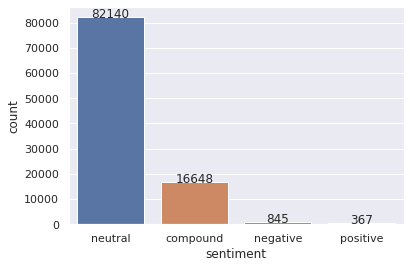

In [ ]:
sns.set(style="darkgrid")
ax = sns.countplot(x='sentiment', data=temp)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

Neutral Words


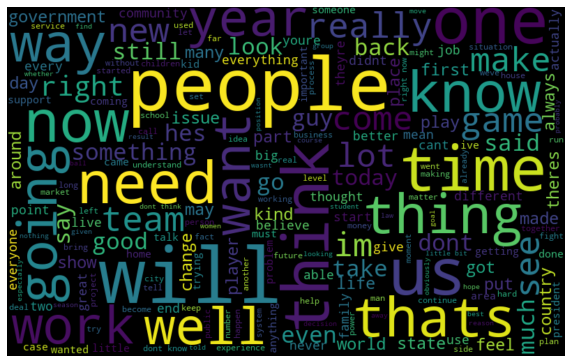

Negative Words


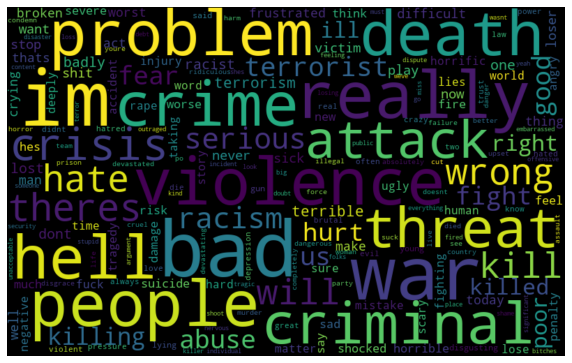

Positive Words


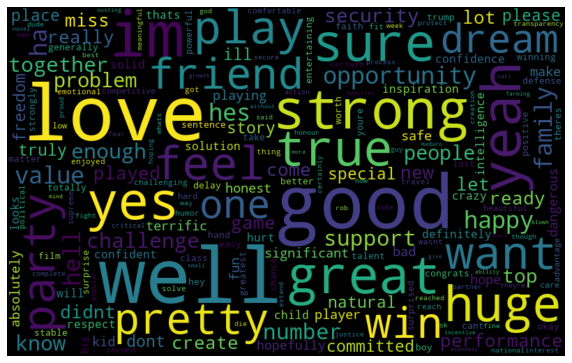

Compound Words


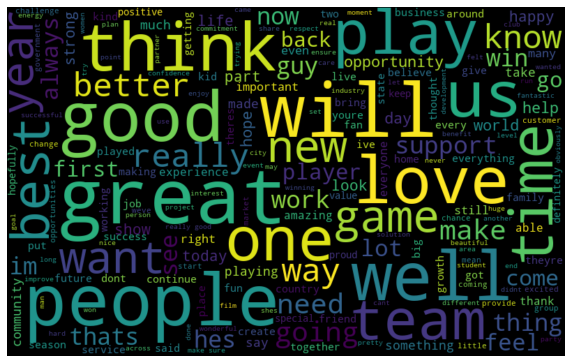

In [ ]:
print("Neutral Words")

neu_words =' '.join([text for text in df['quotation'][df['sentiment'] == 1]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(neu_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

print("Negative Words")

neg_words =' '.join([text for text in df['quotation'][df['sentiment'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(neg_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

print("Positive Words")

pos_words =' '.join([text for text in df['quotation'][df['sentiment'] == 2]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(pos_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

print("Compound Words")

compound_words =' '.join([text for text in df['quotation'][df['sentiment'] == 3]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(compound_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


In [ ]:
import torch

#Flair Sentiment Analyzer

In [ ]:
#flair.device = torch.device('cuda')
flair_sentiment = flair.models.TextClassifier.load('sentiment-fast')

def classify_sentiment_flair(doc):
   #Use flair sentiment analyser to generate scores for each quote
   s = flair.data.Sentence(doc)
   flair_sentiment.predict(s)
   scores = s.labels[0]
   return scores.value
  

applied_df_flair= data.copy()
applied_df_flair['sentiment'] = applied_df_flair['quotation'].apply(lambda quote: classify_sentiment_flair(quote))
applied_df_flair.head()

2021-12-17 18:22:23,683 https://nlp.informatik.hu-berlin.de/resources/models/sentiment-curated-fasttext-rnn/sentiment-en-mix-ft-rnn_v8.pt not found in cache, downloading to /tmp/tmp56c5jjy9


100%|██████████| 1241977025/1241977025 [00:55<00:00, 22556522.22B/s]

2021-12-17 18:23:19,097 copying /tmp/tmp56c5jjy9 to cache at /root/.flair/models/sentiment-en-mix-ft-rnn_v8.pt


2021-12-17 18:23:23,536 removing temp file /tmp/tmp56c5jjy9
2021-12-17 18:23:23,702 loading file /root/.flair/models/sentiment-en-mix-ft-rnn_v8.pt


,quoteID,quotation,speaker,date,numOccurrences,urls_parse,aliases,nationality,occupation,party,sentiment
0,2019-04-08-048753,it is immoral it is harmful it is hurtful,President Donald Trump,2019-04-08 16:22:00,44,www.mercedsunstar.com,NaN,NaN,NaN,NaN,NEGATIVE
1,2019-05-15-053302,it is important for our equine science student...,Sally Johnson,2019-05-15 18:03:22,1,www.lanereport.com,NaN,['United States of America'],['winegrower'],NaN,POSITIVE
2,2019-02-27-055406,it is important to many native american tribes...,Rafael Ortega,2019-02-27 00:00:00,1,kstp.com,['Rafael Angel Ortega'],['Venezuela'],['baseball player'],NaN,NEGATIVE
3,2019-12-08-023053,it is impossible biologically truly to restore...,Barry Lopez,2019-12-08 06:00:00,1,www.timescolonist.com,['Barry Holstun Lopez'],['United States of America'],"['writer', 'photographer']",NaN,NEGATIVE
4,2019-02-21-000088,chilton put it on a little tape recorder and t...,Sam the Sham,2019-02-21 11:05:34,1,www.nashvillescene.com,['Domingo Samudio'],['United States of America'],['singer-songwriter'],NaN,NEGATIVE


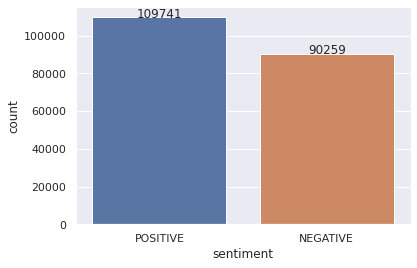

In [ ]:
sns.set(style="darkgrid")
ax = sns.countplot(x='sentiment', data=applied_df_flair[['quotation','sentiment']],order = applied_df_flair['sentiment'].value_counts().index)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

Positive Words


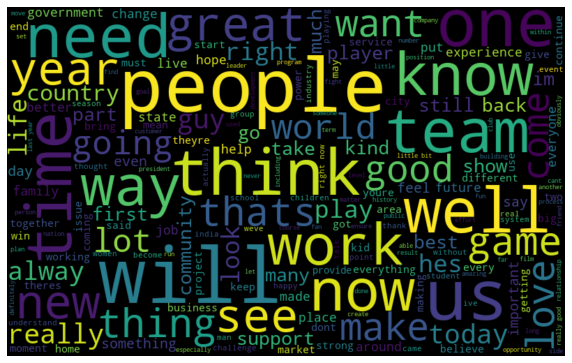

Negative Words


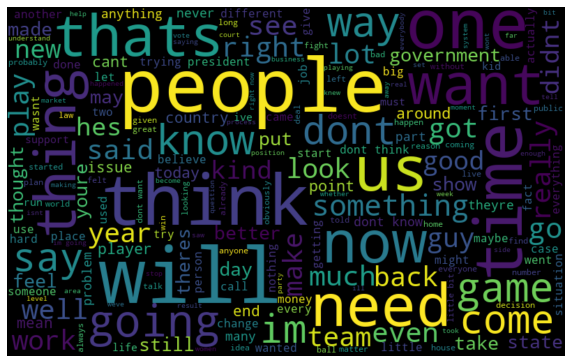

In [ ]:
df=applied_df_flair.copy()
print("Positive Words")

neu_words =' '.join([text for text in df['quotation'][df['sentiment'] == 'POSITIVE']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(neu_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

print("Negative Words")

neg_words =' '.join([text for text in df['quotation'][df['sentiment'] == 'NEGATIVE']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(neg_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# BERTtopic

In [ ]:
from bertopic import BERTopic
topic_model = BERTopic(verbose=True)

In [ ]:
dataset = data[['quotation', 'date']]
dataset.head()

,quotation,date
0,it is immoral it is harmful it is hurtful,2019-04-08 16:22:00
1,it is important for our equine science student...,2019-05-15 18:03:22
2,it is important to many native american tribes...,2019-02-27 00:00:00
3,it is impossible biologically truly to restore...,2019-12-08 06:00:00
4,chilton put it on a little tape recorder and t...,2019-02-21 11:05:34


In [ ]:
def remove_stop(document):
    document = ' '.join(word for word in document.split() if word.lower() not in STOPWORDS) 
    return document
#remove stopwords before topic extraction
dataset['quotation']=dataset['quotation'].apply(lambda x: remove_stop(x))
dataset.head()

,quotation,date
0,immoral harmful hurtful,2019-04-08 16:22:00
1,important equine science students wanting ente...,2019-05-15 18:03:22
2,important many native american tribes need con...,2019-02-27 00:00:00
3,impossible biologically truly restore landscap...,2019-12-08 06:00:00
4,chilton put little tape recorder took ardent s...,2019-02-21 11:05:34


In [ ]:
#sample=dataset.sample(n=100000,random_state=0)# sample size since model runs out of ram 
sample = dataset
sample.reset_index(inplace=True,drop=True)
sample.head()

,quotation,date
0,immoral harmful hurtful,2019-04-08 16:22:00
1,important equine science students wanting ente...,2019-05-15 18:03:22
2,important many native american tribes need con...,2019-02-27 00:00:00
3,impossible biologically truly restore landscap...,2019-12-08 06:00:00
4,chilton put little tape recorder took ardent s...,2019-02-21 11:05:34


In [ ]:
data=sample['quotation'].values.tolist()
timestamps=sample['date'].values.tolist()

In [ ]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words="english", min_df=10)
topic_model = BERTopic(vectorizer_model=vectorizer_model,verbose=True, calculate_probabilities=False)

In [ ]:
topics, probs = topic_model.fit_transform(data)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/3125 [00:00<?, ?it/s]

2021-12-15 16:02:38,611 - BERTopic - Transformed documents to Embeddings
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
2021-12-15 16:05:50,699 - BERTopic - Reduced dimensionality with UMAP
2021-12-15 16:06:06,754 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [ ]:
freq = topic_model.get_topic_info(); freq.head(10)

,Topic,Count,Name
0,-1,54891,-1_hes_game_team_people
1,0,1132,0_music_songs_song_band
2,1,874,1_election_vote_democrats_voters
3,2,870,2_food_eat_wine_restaurant
4,3,788,3_film_films_movie_actor
5,4,787,4_students_teachers_school_schools
6,5,642,5_health_health care_care_healthcare
7,6,582,6_modi_congress_party_minister
8,7,538,7_test_india_world cup_runs
9,8,495,8_bus_traffic_road_roads


In [ ]:
topics_over_time = topic_model.topics_over_time(data, topics, timestamps, nr_bins=20)
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=10)

20it [00:17,  1.12it/s]


In [ ]:
#topics_over_time.write_html("topics_over_time_2020.html", include_plotlyjs="cdn")
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=10).write_html("topics_over_time_2019.html", include_plotlyjs="cdn")

In [ ]:
fig = topic_model.visualize_topics(); fig

In [ ]:
topic_nr = freq.iloc[0]["Topic"]  # We select a frequent topic
topic_model.get_topic(topic_nr)   # You can select a topic number as shown above

[('hes', 0.001244543415459268),
 ('game', 0.0012430844123715696),
 ('team', 0.0012189741728187253),
 ('people', 0.0011803699447130742),
 ('play', 0.001173026135326073),
 ('going', 0.001170798216048957),
 ('really', 0.001165333525697218),
 ('like', 0.001162340457846796),
 ('work', 0.0011621117488177493),
 ('good', 0.0011608338959669718)]

topics_over_time.write_html("topics_over_time.html", include_plotlyjs="cdn")

In [ ]:
fig.write_html("Intertropic_distance_2019.html", include_plotlyjs="cdn")

/content
